In [ ]:
import pandas as pd
import numpy as np
import itertools
import openpyxl
import datetime
import jieba
import re
import datetime
from collections import Counter
from matplotlib import pyplot as plt
import ckipnlp

df = pd.read_excel("2013-2022 鴻海官方新聞稿input.xlsx")

# date: 2022/11/10

### Step7: 依據分析結果設計word dictionary

In [2]:
collective_strategies = {
    '資源': '整合, 合資, 共組, 結合, 投資, 入股, 認購, 併購, 研究院',
    '協作': '結盟, 夥伴, 串連, 加入, 聯盟, 策略, 第三方, 分享, 一同, 合作, 彼此, 共同, 攜手, 合力, 生態, 共生, 共享, 攜手, 打造, 共創',
    '平台': '標準, 模組, 門檻, 開放, 平台, 介面, 互聯, 共用, 共享, 通用, 存取, 重複, 使用, 底盤, model, 參考, 公版',    
}
    
individual_strategies = {
    '競爭力': '優勢, 最佳, 優異, 卓越, 第一, 領先, 標竿, 百大, 專業, 經驗',
    '差異性': '不同, 獨特, 專利',
    '突破性': '改變, 開創',
    '市場領導': '帶領, 引領',
}

#################################################
#################### 呈現策略 ####################
#################################################

# 差異化策略
individual_kws = sum([kws.split(', ') for strategy, kws in individual_strategies.items()], [])

# 正當化策略
collective_kws = sum([kws.split(', ') for strategy, kws in collective_strategies.items()], [])

# 將正當化策略拆分成－資源、協作、平台策略
resource_kws = collective_strategies['資源'].split(', ')
cooperate_kws = collective_strategies['協作'].split(', ')
platform_kws = collective_strategies['平台'].split(', ')

# 將正當化策略－協作與平台策略合併
cooperate_platform_kws = cooperate_kws + platform_kws

# 所有策略
all_kws = individual_kws + resource_kws + cooperate_platform_kws

### Step8-1: 載入辭庫 / 過濾新聞稿

1. [jieba-documentation](https://github.com/fxsjy/jieba)
2. [下載中文詞庫和停用詞](https://github.com/GoatWang/ithome_ironman/tree/master/day16_NLP_Chinese)

In [3]:
# 安裝中文詞庫 & 自建詞庫
jieba.set_dictionary('word_bags/dict.txt.big')
jieba.load_userdict("word_bags/userdict.txt")
print(jieba.__file__)

# 載入停用詞
with open('word_bags/stops.txt', 'r', encoding='utf8') as f:
    stops = f.read().split('\n') 

add_stops = ['\n', '\n\n', ' ', '】', '【', ',', '・']
stops += add_stops

Building prefix dict from C:\Users\Penny\Documents\00 成大企研\111.10 MIH 電動車平台\2023.11.20 鴻海官方新聞稿NLP字頻分析\word_bags\dict.txt.big ...
Loading model from cache C:\Users\Penny\AppData\Local\Temp\jieba.u804a96fc51e5688b42b579afefcea801.cache
Loading model cost 0.744 seconds.
Prefix dict has been built successfully.


C:\Users\Penny\anaconda3\lib\site-packages\jieba\__init__.py


In [4]:
# 過濾與車及MIH相關之新聞稿

links = "(((https:|http:)+(//[A-Za-z0-9\/+=%&_\:.~?\-]+))[\)\]]*|www.honhai.com)"
number = "[0-9]"

relative_to_car = []
result_dict = {}

for news in df['content']:
    if "車" in str(news) or "MIH" in str(news):
        relative_to_car.append(1)
    else:
        relative_to_car.append(0)

        
if 'relative_to_car' not in df.columns:
    df['relative_to_car'] = relative_to_car
    
car_related = df.loc[df['relative_to_car'] == 1]

### 補充－針對全文斷字與檢視詞會出現次數

#### 清除停用詞、網址、英文、數字並進行斷字

In [ ]:
for idx, row in car_related.iterrows():
    cleaned = row['content']
    cleaned = re.sub(links,"",cleaned)
    cleaned = re.sub(number,"",cleaned)
    terms = [t for t in jieba.cut(cleaned) if t not in stops]
    
    result_dict[row['title']] = {
        'date': row['date'],
        'terms': terms
    }
    
print('與車及MIH相關之新聞稿總數:', len(result_dict))

#### 以第一篇新聞稿為例，呈現斷字結果

In [6]:
print(result_dict['沙烏地阿拉伯國家電動車品牌 CEER正式登場'].keys())
print(result_dict['沙烏地阿拉伯國家電動車品牌 CEER正式登場']['date'])
print(result_dict['沙烏地阿拉伯國家電動車品牌 CEER正式登場']['terms'][:20])

dict_keys(['date', 'terms'])
2022-11-03 00:00:00
['利雅得', '年月日', '沙烏地阿', '拉伯', '總理', '兼', '公共', '投資', '基金', 'PIF', '主席', '穆罕默德', 'Mohammad', 'bin', 'Salman', 'bin', 'Abdulaziz', '王儲', '殿下', '今天']


#### 將斷詞結果轉換為詞袋，作為語料來源

In [59]:
from gensim import corpora, models, similarities
from gensim import matutils

DEMO_WORD = '電動車'

# step-1: 將斷詞結果作為語料來源 (存放所有斷詞結果)
documents = [article['terms'] for title, article in result_dict.items()]

# step-2: 整合所有語料至詞袋中(bag of word)，並設置對應編號 (ex. 電動車: 114號)
dictionary = corpora.Dictionary(documents)
id_of_DEMO_WORD = dictionary.token2id[f"{DEMO_WORD}"]


print(f'===== 將斷詞儲存在詞袋中，其中共有{len(dictionary)}個詞彙，每個詞彙都有對應編號 =====')
print(f'如："{DEMO_WORD}"字詞為編號{id_of_DEMO_WORD}') # 詞項在字典中各自對應的編號

# step-3: 計算每篇新聞稿中，各字詞出現次數 (token_id, token_count)

corpus = [dictionary.doc2bow(text) for text in documents]

print(f'===== 計算每篇新聞稿中，各字詞出現次數 =====')
print(f'如：第一篇新聞稿出現{len(corpus[0])}個詞彙，第一個詞彙資料為{corpus[0][0]}')
print(f'詞彙資料中，{corpus[0][0][0]}代表詞彙id，{corpus[0][0][1]}代表詞彙在本文中出現次數')

===== 將斷詞儲存在詞袋中，其中共有6992個詞彙，每個詞彙都有對應編號 =====
如："電動車"字詞為編號159
===== 計算每篇新聞稿中，各字詞出現次數 =====
如：第一篇新聞稿出現169個詞彙，第一個詞彙資料為(0, 2)
詞彙資料中，0代表詞彙id，2代表詞彙在本文中出現次數


#### 將語料庫轉成 字詞-文本矩陣(TDM)，其值即為詞會出現次數
1. Document-Term Matrix (文本字詞矩陣, DTM)
    * 以row代表文本，以column代表字詞
2. Term-Document Matrix (字詞文本矩陣, TDM)
    * 以row代表字詞，以column代表文本

In [62]:
numpy_matrix = matutils.corpus2dense(corpus, num_terms=len(dictionary))
print(f'計算出－字詞-文本矩陣(TMD): {numpy_matrix.shape[0]}的字詞分別在 {numpy_matrix.shape[1]}篇文本中出現的次數')
print(numpy_matrix)

6992
計算出－字詞-文本矩陣(TMD): 6992的字詞分別在 95篇文本中出現的次數
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [10.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  2.]]


### Step8-2: 詞頻分析 & 特徵值萃取
* Term Frequency-Inverse Document Frequency(詞頻－逆文件頻率，TF-IDF)
    * 一種用於資料檢索與文字探勘的常用加權技術，為一種統計方法，用來評估詞項對於語料庫獲一份文件的重要程度。
* Term-Frequency 詞頻：這個字在這篇文章中出現的頻率(TF)
    * TF = 詞項的出現次數/該篇文章的總詞數
* Inverse-Document-Frequency 逆文件頻率：所有文件中，有幾篇出現該詞項(IDF)
    * IDF = log(總文件數/出現該字詞的文件數)
* 詞項的重要性 = TF * IDF

#### step8-2-1: 建立語料庫，進行斷詞

In [11]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []

for idx, row in car_related.iterrows():
    cleaned = row['content']
    cleaned = re.sub(links,"",cleaned)
    cleaned = re.sub(number,"",cleaned)
    cleaned = re.sub(r'\s',"",cleaned)
    
    corpus.append('|'.join(jieba.cut(cleaned.strip())))
    
print(f'總共拆成{len(corpus)}篇斷字文本，示例如下：')
print(corpus[0])

總共拆成95篇斷字文本，示例如下：
【|利雅得|，|年月日|】|沙烏地阿|拉伯|總理|兼|公共|投資|基金|(|PIF|)|主席|穆罕默德|（|MohammadbinSalmanbinAbdulaziz|）|王儲|殿下|今天|正式|對外|宣布|Ceer|公司|的|成立|，|作為|沙國|第一個|國家|電動汽車|品牌|，|將為|沙國|汽車產業|做出|貢獻|。|Ceer|公司|的|成立|符合|PIF|致力於|推動|沙國|前瞻|產業|的|策略|，|作為|推動|沙國|經濟|多元化|的|戰略|之一|，|幫助|沙國|實現|年|願景|的|目標|。|此外|，|公司|將為|沙國|減少|碳|排放|，|推動|可|持續|發展|以|應對|氣候變化|的|努力|中|作出貢獻|。|穆罕默德|（|MohammadbinSalmanbinAbdulaziz|）|王儲|殿下|表示|：|「|沙烏地阿|拉伯|不僅|要|打造|一個|新|的|汽車品牌|，|我們|正在|點燃|一個|新|的|產業|和|生態系統|，|吸引|國際|和|在|地|投資|，|並為|當地|人才|創造|民間|就業機會|。|Ceer|作為|PIF|協助|推動|年|願景|，|擘畫|經濟|增長|戰略|的|一部分|，|將在|未來|十年|內為|沙烏地阿|拉伯|的|GDP|作出貢獻|。|」|Ceer|將是|第一個|在|沙國|生產|電動車|的|沙國|汽車品牌|公司|，|目標|為|沙國|和|中東|、|北非地區|的|消費者|設計|、|製造|和|銷售|一系列|電動車|，|包括|轎車|和|休旅車|。|Ceer|公司|就是|PIF|透過|投資|有|前景|的|產業|，|以|實現|沙國|GDP|增長|多元化|戰略|的|一部分|。|預計|Ceer|將|吸引|超過|.|億美元|的|外國|直接|投資|，|並|創造|多達|,|個|直接|和|間接|就業機會|，|預計|到|年|將為|沙國|的|GDP|貢獻|億美元|。|Ceer|公司|是|PIF|和|鴻海|的|合資企業|，|將會|運用|BMW|授權|的|零部件|技術|於|車輛|開發|過程|中|。|鴻海|將|開發|車輛|的|電子|電氣|架構|，|並且|在|智能|座艙|、|智能網|關和|自動|輔助|駕駛|技術|領域|提供|工程|產品|服務|。|每輛車|都|將在|沙國|設計|和|製造|，|並|按照|全球|最高|規格|的|汽車|品質|和|安全|標

#### step8-2-2: 運算取得tf-idf matrix (詞頻－逆文件頻率矩陣)

In [12]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
tfidf_matrix = tfidf.toarray()

print(f'建立出矩陣大小為：{tfidf.shape}') # 
print(f'代表總有{tfidf.shape[0]}份文件，{tfidf.shape[1]}個詞項')

建立出矩陣大小為：(95, 6551)
代表總有95份文件，6551個詞項


#### step8-2-3: 取得所有文件之字詞特徵

In [33]:
wordfeatures = vectorizer.get_feature_names_out()
# print(wordfeatures)

THRESHOLD = 0.1
print(f'列印每份文件中，tf-idf value大於{THRESHOLD}的關鍵字及對應值')


for i in range(len(corpus)):
    if i == 10:
        print('\n\n',f'==== Document {i} ====')
        for j in range(len(wordfeatures)):
            if tfidf[i,j] > THRESHOLD:
                print(wordfeatures[j], tfidf[i, j])

列印每份文件中，tf-idf value大於0.1的關鍵字及對應值


 ==== Document 10 ====
edwardhightower 0.22565212329973658
lmc 0.1551521051440058
mih 0.35621468964344594
techstars 0.16923909247480243
triciamartinez 0.22565212329973658
創業家 0.11282606164986829
加速器 0.11282606164986829
執行長 0.1551017788218606
委員會 0.14265116978368286
工作 0.11054201791285383
擔任 0.2266454722017802
新創 0.13894329427192542
會策 0.11282606164986829
程序 0.11282606164986829
美國 0.11054201791285383
聯盟 0.15030776973394325
董事 0.11001139495574447
透明度 0.10343473676267052
選舉 0.16923909247480243
電動車 0.10326970212247435
顧問 0.14515722857168062


### Step8-3: 企業策略分析

In [86]:
release_year = [time.strftime('%Y-%m-%d') for time in list(car_related.date)]
news_title = [title for title in list(car_related.title)]
wordfeatures = list(wordfeatures)


# 差異化策略
individual_ratio = []
individual_index_in_wf = [wordfeatures.index(kw) for kw in individual_kws]

# 正當化策略
collective_ratio = []
collective_index_in_wf = [wordfeatures.index(kw) for kw in collective_kws]

# 將正當化策略拆分成－資源、協作、平台策略
resource_ratio = []
cooperate_ratio = []
platform_ratio = []
resource_index_in_wf = [wordfeatures.index(kw) for kw in resource_kws]
cooperate_index_in_wf = [wordfeatures.index(kw) for kw in cooperate_kws]
platform_index_in_wf = [wordfeatures.index(kw) for kw in platform_kws]

# 將正當化策略－協作與平台策略合併
cooperate_platform_ratio = []
cooperate_platform_index_in_wf = [wordfeatures.index(kw) for kw in cooperate_platform_kws]


# 所有策略
all_ratio = []
all_index_in_wf = [wordfeatures.index(kw) for kw in all_kws]

In [87]:
def get_strategy_score(news_id, strategy_word_id):
    
    news_with_strategies = 0
    strategies_score = 1

    for word_id in strategy_word_id:

        if tfidf[news_id, word_id] > 0:
            news_with_strategies += 1
            strategies_score *= tfidf[news_id, word_id]

    if news_with_strategies == 0:
        return 0

    else:
        return strategies_score ** (1/news_with_strategies)
        
    
for news_id in range(len(corpus)):
    
    # 差異化策略 individual
    individual_ratio.append(get_strategy_score(news_id, individual_index_in_wf))

    # 正當化策略 collective
    collective_ratio.append(get_strategy_score(news_id, collective_index_in_wf))
    
    # 將正當化策略拆分成－資源、協作、平台策略
    resource_ratio.append(get_strategy_score(news_id, resource_index_in_wf))
    cooperate_ratio.append(get_strategy_score(news_id, cooperate_index_in_wf))
    platform_ratio.append(get_strategy_score(news_id, platform_index_in_wf))
    
    # 將正當化策略－協作與平台策略合併
    cooperate_platform_ratio.append(get_strategy_score(news_id, cooperate_platform_index_in_wf))
    # 所有策略
    all_ratio.append(get_strategy_score(news_id, all_index_in_wf))

#### 呈現高分之新聞稿與關鍵字

In [78]:
def show_detail(word_feature, ratio, score):
    for news_id in range(len(corpus)):

        if ratio[news_id] >= score:

            print('\n', f'==== {news_id} {release_year[news_id]} {news_title[news_id][:30]}... ====')
            print('individual 分數: ', "{:.3f}".format(ratio[news_id]))

            for word_id in word_feature:
                if tfidf[news_id,word_id] > 0:
                    print(wordfeatures[word_id], "{:.3f}".format(tfidf[news_id, word_id]))

all_strategies = {
    'individual':[individual_index_in_wf, individual_ratio],
    'collective':[collective_index_in_wf, collective_ratio],
    'resource':[resource_index_in_wf, resource_ratio],
    'cooperate':[cooperate_index_in_wf, cooperate_ratio],
    'platform':[platform_index_in_wf, platform_ratio],
    'cooperate_platform':[cooperate_platform_index_in_wf, cooperate_platform_ratio],
    'all':[all_index_in_wf, all_ratio],
}

In [82]:
TARGET_STRATEGY = 'individual'
SHOW_SCORE_ABOVE = 0.05

show_detail(all_strategies[TARGET_STRATEGY][0], all_strategies[TARGET_STRATEGY][1], SHOW_SCORE_ABOVE)

#### 輸出詞頻統計結果excel檔

In [89]:
## 只執行一次

release_year.reverse()
news_title.reverse()

collective_ratio.reverse()
individual_ratio.reverse()
resource_ratio.reverse()
cooperate_ratio.reverse()
platform_ratio.reverse()
cooperate_platform_ratio.reverse()
all_ratio.reverse()

In [92]:
result_ratio = pd.DataFrame({'date':release_year, 
                             'title':news_title,
                             'all':all_ratio,
                             'collective':collective_ratio, 
                             'individual':individual_ratio,
                            'resource':resource_ratio,
                            'cooperate':cooperate_ratio,
                            'platform':platform_ratio,
                            'cooperate_platform':cooperate_platform_ratio
                            })
result_ratio

#################### 只 print 分數高的策略 ####################

# significant = pd.DataFrame()

# level = 0

# significant = pd.concat([significant,result_ratio[result_ratio.individual >= level]]).drop_duplicates().reset_index(drop=True)
# significant = pd.concat([significant,result_ratio[result_ratio.resource >= level]]).drop_duplicates().reset_index(drop=True)
# significant = pd.concat([significant,result_ratio[result_ratio.cooperate >= level]]).drop_duplicates().reset_index(drop=True)
# significant = pd.concat([significant,result_ratio[result_ratio.platform >= level]]).drop_duplicates().reset_index(drop=True)
# significant.sort_values(by='date')

# significant.to_excel(f'{str(datetime.datetime.now()).split(" ")[0]}-above{level}.xlsx', encoding='utf_8_sig',index=False)

In [ ]:
# result_ratio.to_excel('鴻海詞頻統計.xlsx', encoding='utf_8_sig', index=False)

#### 輸出詞頻統計png圖示

C:\Users\Penny\AppData\Local\Temp\ipykernel_4608\3106140224.py:9: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'title'], dtype='object')
  roll_df = result_ratio.rolling(window=6).mean()


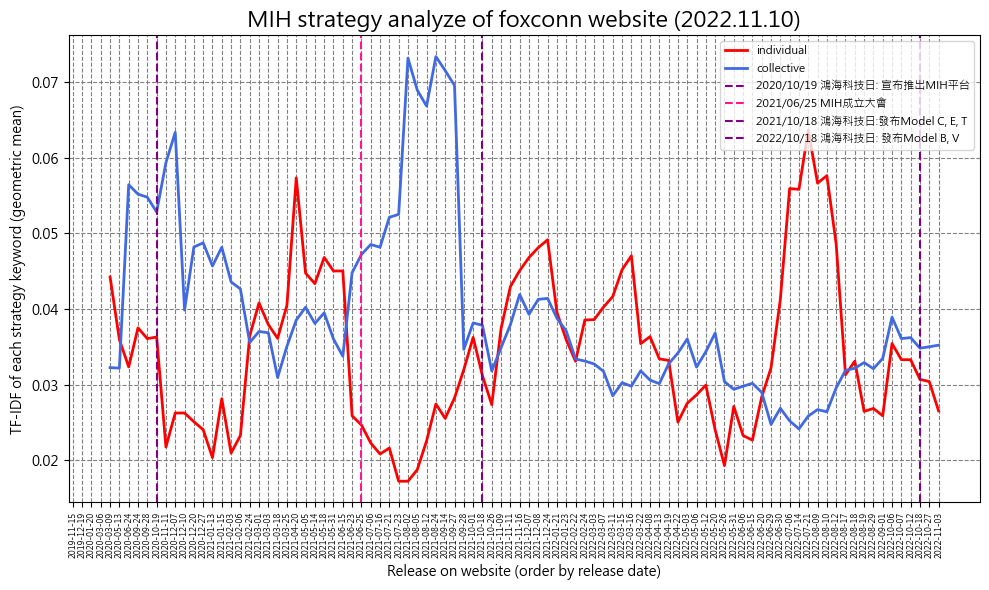

In [98]:
import matplotlib.pyplot as plt

plt.rc('font', family='Microsoft JhengHei') # 微軟正黑體
plt.figure(figsize=(10,6), dpi=100)
plt.title("MIH strategy analyze of foxconn website (2022.11.10)", fontsize=16) 
plt.grid(color='grey', linestyle='--')

roll_df = result_ratio.rolling(window=6).mean()

plt.xlabel('Release on website (order by release date)', fontsize=10)
plt.ylabel('TF-IDF of each strategy keyword (geometric mean)', fontsize=10)
plt.xticks(fontsize=6, rotation=90)


#################################################
#################### 呈現策略 ####################
#################################################

# plt.plot(result_ratio.date, roll_df['all'], color="yellow", linewidth=2, label='individual+collective')
plt.plot(result_ratio.date, roll_df.individual, color="red", linewidth=2, label='individual')
# plt.plot(result_ratio.date, roll_df.resource, color="lime", linewidth=2,  label='resource(差異性)')
# plt.plot(result_ratio.date, roll_df.cooperate_platform, color="royalblue", linewidth=2,  label='cooperate & platform(一致性)')
plt.plot(result_ratio.date, roll_df.collective, color="royalblue", linewidth=2,  label='collective')
# plt.plot(result_ratio.date, roll_df.cooperate, color="green", linewidth=2,  label='cooperate')
# plt.plot(result_ratio.date, roll_df.platform, color="greenyellow", linewidth=2,  label='platform')


#################### 新增重要事件 ####################

# 2020/10/16(19) 鴻海科技日：推出電動車 MIH 開放平台，宣告集團已經準備好正式進軍電動車領域
plt.axvline(x='2020-10-19', label='2020/10/19 鴻海科技日: 宣布推出MIH平台', linestyle='--',c='purple')
# 2021/6/25 MIH成立大會
plt.axvline(x='2021-06-25', label='2021/06/25 MIH成立大會', linestyle='--',c='deeppink')
# 2021/10/18 鴻海科技日：發布 MODEL C、MODEL E、MODEL T
plt.axvline(x='2021-10-18', label='2021/10/18 鴻海科技日:發布Model C, E, T', linestyle='--',c='purple')
# 2022/10/18 鴻海科技日：發布 MODEL B、MODEL V
plt.axvline(x='2022-10-18', label='2022/10/18 鴻海科技日: 發布Model B, V', linestyle='--',c='purple')

plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


#################### 輸出檔案 ####################

# plt.savefig('分析結果圖檔/result.png')